In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Vivino Napa Valley Wine Data: Data Cleaning and Exploration




In [2]:
wine_data = pd.read_csv('../wine_data/wine_data_combined.csv')
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4425 entries, 0 to 4424
Data columns (total 43 columns):
grape_Sauvignon Blanc          84 non-null float64
grape_Pinot Gris               9 non-null float64
wine_type                      4425 non-null object
flavor_score_red_fruit         4403 non-null float64
flavor_score_spices            4407 non-null float64
grape_Pinot Noir               651 non-null float64
flavor_score_citrus_fruit      4216 non-null float64
grape_Petite Sirah             25 non-null float64
grape_Mourvedre                6 non-null float64
taste_acidity                  4375 non-null float64
flavor_score_black_fruit       4376 non-null float64
grape_Petit Verdot             162 non-null float64
flavor_score_tropical_fruit    3679 non-null float64
grape_Cabernet Sauvignon       2527 non-null float64
grape_Merlot                   1110 non-null float64
grape_Gewürztraminer           5 non-null float64
grape_Carménère                59 non-null float64
flavor_sco

In [3]:
# organize the columns 
columns = list(wine_data.columns)

# isolate taste, flavor and grape feature columns
taste_columns = [col for col in columns if col.startswith('taste')]
flavor_columns = [col for col in columns if col.startswith('flavor')]
grape_columns = [col for col in columns if col.startswith('grape')]
other_columns = ['wine_name', 'vintage', 'winery_name', 'wine_style','wine_type',
                 'natural_wine', 'ratings_average', 'ratings_count']

# sort feature columns
taste_columns.sort()
flavor_columns.sort()
grape_columns.sort()

# recombine columns in preferred order
columns = other_columns + taste_columns + flavor_columns + grape_columns

# update dataframe
wine_data = wine_data[columns]

pd.set_option('display.max_columns', None)
wine_data.head(10)

,wine_name,vintage,winery_name,wine_style,wine_type,natural_wine,ratings_average,ratings_count,taste_acidity,taste_fizziness,taste_intensity,taste_sweetness,taste_tannin,flavor_score_black_fruit,flavor_score_citrus_fruit,flavor_score_dried_fruit,flavor_score_earth,flavor_score_floral,flavor_score_microbio,flavor_score_non_oak,flavor_score_oak,flavor_score_red_fruit,flavor_score_spices,flavor_score_tree_fruit,flavor_score_tropical_fruit,flavor_score_vegetal,grape_Cabernet Franc,grape_Cabernet Sauvignon,grape_Carménère,grape_Chardonnay,grape_Gewürztraminer,grape_Grenache,grape_Malbec,grape_Merlot,grape_Mourvedre,grape_Petit Verdot,grape_Petite Sirah,grape_Pinot Gris,grape_Pinot Noir,grape_Sauvignon Blanc,grape_Shiraz/Syrah,grape_Sémillon,grape_Zinfandel
0,Ravenswood Old Vine Zinfandel 2013,2013,Ravenswood,Californian Zinfandel,Old Vine Zinfandel,False,3.7,2129,1.787345,NaN,4.864060,2.521236,2.506278,0.206729,0.004206,0.029764,0.098997,0.005176,0.021999,0.120026,0.223876,0.171466,0.108056,0.002588,0.000971,0.006147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,Beringer Founders' Estate Zinfandel 2017,2017,Beringer,Californian Zinfandel,Founders' Estate Zinfandel,False,3.8,2126,1.792486,NaN,4.624084,2.870854,2.491485,0.172686,0.005643,0.034989,0.071106,0.007901,0.020316,0.137698,0.191874,0.185102,0.146727,0.010158,0.004515,0.011287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,Ravage Cabernet Sauvignon 2014,2014,Ravage,Californian Cabernet Sauvignon,Cabernet Sauvignon,False,3.7,2126,2.981454,NaN,4.875816,1.858709,3.338571,0.147925,0.001887,0.008302,0.147170,0.004906,0.023019,0.182264,0.265660,0.090189,0.120755,0.004528,0.000377,0.003019,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Goldeneye Anderson Valley Pinot Noir 2016,2016,Goldeneye,Californian Pinot Noir,Anderson Valley Pinot Noir,False,4.3,2125,3.448754,NaN,3.104253,1.595988,2.049438,0.102472,0.003190,0.016746,0.140351,0.015152,0.029506,0.132376,0.207735,0.220494,0.110447,0.006380,0.000399,0.014753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,Wente Southern Hills Cabernet Sauvignon 2015,2015,Wente,Californian Cabernet Sauvignon,Southern Hills Cabernet Sauvignon,False,3.8,2123,3.010710,NaN,4.800049,1.601238,3.398032,0.210114,0.003920,0.017248,0.087417,0.003528,0.022344,0.128185,0.224226,0.183457,0.105057,0.005096,0.001960,0.007448,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Ravenswood Besieged 2014,2014,Ravenswood,Californian Red Blend,Besieged,False,3.7,2122,3.929321,NaN,4.910671,1.548535,3.339163,0.273326,NaN,0.007684,0.111965,0.009879,0.034029,0.096597,0.187706,0.185510,0.084523,0.004391,0.002195,0.002195,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
6,Stags' Leap Petite Sirah 2014,2014,Stags' Leap,Californian Petite Sirah,Petite Sirah,False,4.2,2116,3.475870,NaN,4.469186,1.589262,4.330360,0.230153,0.003005,0.019534,0.135988,0.018282,0.024293,0.121212,0.220887,0.095417,0.114200,0.005259,0.001503,0.010268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
7,Orin Swift Abstract 2012,2012,Orin Swift,Californian Red Blend,Abstract,False,4.1,2116,3.827420,NaN,4.875993,1.785856,3.422629,0.183082,0.003853,0.022278,0.111558,0.012395,0.026633,0.142211,0.225293,0.129816,0.128476,0.003015,0.001005,0.010385,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
8,Freemark Abbey Cabernet Sauvignon 2012,2012,Freemark Abbey,Napa Valley Cabernet Sauvignon,Cabernet Sauvignon,False,4.2,2115,3.437202,NaN,4.826581,1.509323,3.485361,0.185956,0.004768,0.010837,0.133073,0.008669,0.026875,0.140876,0.246641,0.108366,0.116168,0.002601,0.000433,0.014738,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Belle Glos Dairyman Vineyard Pinot Noir 2014,2014,Belle Glos,Californian Pinot Noir,Dairyman Vineyard Pinot Noir,False,4.4,2112,3.390366,NaN,3.336472,1.754696,1.993983,0.120942,0.002298,0.018673,0.094226,0.00

---
## Data Cleaning
The first step is to clean the data.

Before, I seperated three groups of feature columns: taste, flavor, and grape. I'll handle each of these group's null values first, starting with taste.

### Cleaning `taste_` null values
Based on how Vivino specifies "taste" for their wines, it is *possible* that a null value could be interepreted as `0`. For example, I assume that a null value for `taste_fizziness` indicates that a wine isn't judged on that feature because it is *not* a "fizzy" wine *(or at least, it shouldn't be)*.

For other features, like `taste_tannin` I don't want to rush to a quick conclusion. All wine's have tannins, but whites tend to have much less tannins and it is *possible* that a white wine with no tannic taste was scored `0` or `null` on tannic taste. The same reasoning could explain the remaining null values. It should also be noted that `taste_intensity`, which is a bit ambigious, should be interepreted as "boldness", as displayed on the webiste.

In [4]:
wine_data[taste_columns] = wine_data[taste_columns].fillna(0)

### Cleaning `flavor_` null values
The `flavor_score_`'s scraped from vivino are a calculated feature. Users can attribute certain pre-defined flavors to wine when they review it, and a count is kept for each time a review attributes a flavor to the wine. The `flavor_score_` is calculated by dividing the `count_attributed_to_flavor` / `total_count_of_attributions_for_the_wine`. For example, interpreting a flavor score of `0.48` for `oak` means that 48% of the flavors specified by user reviews were `oak`.

Like `taste_` features, I assume that `null` values indicate that a given flavor was not attributed to a wine by any reviews. I will fill `null` values with zero.

In [5]:
wine_data[flavor_columns] = wine_data[flavor_columns].fillna(0)

### Cleaning `grape_` null values
A `grape_` feature is `1` if the grape variety is used in the wine. `null` values for this field indicate that a grape is not present in a wine, and should be interpreted as `0`.

Additionally, these values do not need to be `float`, and can be converted to `int`.

In [6]:
wine_data[grape_columns] = wine_data[grape_columns].fillna(0)

# convert grape_columns from float -> int
for col in grape_columns:
    wine_data[col] = pd.to_numeric(wine_data[col], downcast='integer')

### Final `null` values
The final `null` values are in the `wine_style` column. Since these null values account for less than 1% of the observations and I plan to use this information, I am just going to drop the rows with missing `wine_style`.

In [7]:
wine_data.dropna(subset=['wine_style'], axis=0, inplace=True)

### Remove Duplicate Values
Drop duplicate wines, based on their `wine_name`, `vintage`, `winery_name`, and `wine_style`.

In [8]:
wine_data.drop_duplicates(subset=['wine_name', 'vintage', 'winery_name', 'wine_style'], inplace=True)

### Transform `natural_wine` → `int`

In [9]:
wine_data['natural_wine'] = wine_data['natural_wine'].astype('int8')

### Transform `vintage` → `int`

In [10]:
wine_data['vintage'].value_counts()

2016    338
2014    335
2015    315
2013    288
2012    216
2017    184
2011    107
2018     51
2010     50
2009     18
N.V.     17
2008     14
2006      4
2007      4
1980      3
2005      2
1982      1
1996      1
1997      1
2001      1
2003      1
U.V.      1
2004      1
Name: vintage, dtype: int64

In [11]:
wine_data[(wine_data['vintage']=='U.V.') | (wine_data['vintage']=='N.V.')].sort_values('wine_name')

,wine_name,vintage,winery_name,wine_style,wine_type,natural_wine,ratings_average,ratings_count,taste_acidity,taste_fizziness,taste_intensity,taste_sweetness,taste_tannin,flavor_score_black_fruit,flavor_score_citrus_fruit,flavor_score_dried_fruit,flavor_score_earth,flavor_score_floral,flavor_score_microbio,flavor_score_non_oak,flavor_score_oak,flavor_score_red_fruit,flavor_score_spices,flavor_score_tree_fruit,flavor_score_tropical_fruit,flavor_score_vegetal,grape_Cabernet Franc,grape_Cabernet Sauvignon,grape_Carménère,grape_Chardonnay,grape_Gewürztraminer,grape_Grenache,grape_Malbec,grape_Merlot,grape_Mourvedre,grape_Petit Verdot,grape_Petite Sirah,grape_Pinot Gris,grape_Pinot Noir,grape_Sauvignon Blanc,grape_Shiraz/Syrah,grape_Sémillon,grape_Zinfandel
1279,American Wings Zinfandel,N.V.,American Wings,Californian Zinfandel,Zinfandel,0,3.7,2428,1.859404,0.000000,4.601834,2.864984,2.348025,0.230303,0.000000,0.024242,0.072727,0.012121,0.012121,0.090909,0.242424,0.139394,0.169697,0.006061,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3862,Bedrock Wine Co. Shebang,N.V.,Bedrock Wine Co.,Californian Red Blend,Shebang,0,3.5,2719,3.853599,0.000000,4.855088,1.833988,3.555330,0.176471,0.009804,0.017157,0.117647,0.014706,0.022059,0.112745,0.225490,0.151961,0.132353,0.004902,0.002451,0.012255,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
458,Black Ridge Pinot Noir,N.V.,Black Ridge,Californian Pinot Noir,Pinot Noir,0,3.6,1469,3.282428,0.000000,3.088728,1.789538,2.091214,0.134387,0.007905,0.015810,0.086957,0.007905,0.015810,0.134387,0.201581,0.276680,0.110672,0.000000,0.003953,0.003953,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1227,Bonanza Cabernet Sauvignon Lot 1,N.V.,Bonanza,Californian Cabernet Sauvignon,Cabernet Sauvignon Lot 1,0,4.1,7821,2.858976,0.000000,4.596515,2.080696,3.011281,0.212008,0.004378,0.028768,0.072545,0.009381,0.013759,0.141964,0.223265,0.150094,0.135084,0.003752,0.000625,0.004378,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2169,Cain Cuvée,N.V.,Cain,Napa Valley Bordeaux Blend,Cuvée,0,4.0,3159,3.747098,0.000000,4.391161,1.524538,3.375198,0.153061,0.001701,0.010204,0.226190,0.020408,0.032313,0.108844,0.226190,0.115646,0.076531,0.001701,0.000000,0.027211,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0
1830,Double Dog Dare Cabernet Sauvignon,N.V.,Double Dog Dare,Californian Cabernet Sauvignon,Cabernet Sauvignon,0,2.9,1050,3.024720,0.000000,4.357280,1.964346,3.387227,0.293103,0.000000,0.034483,0.086207,0.000000,0.017241,0.034483,0.137931,0.344828,0.017241,0.017241,0.000000,0.017241,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3139,Gloria Ferrer Blanc de Noirs,N.V.,Gloria Ferrer,Californian Sparkling,Blanc de Noirs,0,3.8,1667,3.417336,3.992212,3.976343,0.000000,0.000000,0.028747,0.133470,0.008214,0.049281,0.006160,0.123203,0.110883,0.090349,0.225873,0.053388,0.141684,0.012320,0.016427,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2204,Gloria Ferrer Sonoma Brut,N.V.,Gloria Ferrer,Californian Sparkling,Sonoma Brut,0,3.7,2980,3.284146,3.872082,3.588837,0.000000,0.000000,0.007989,0.149134,0.000000,0.079893,0.009321,0.149134,0.123835,0.078562,0.038615,0.021305,0.268975,0.023968,0.049268,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
365,J Vineyards Cuvée 20 Brut,N.V.,J Vineyards,Californian Sparkling,Cuvée 20 Brut,0,4.0,940,3.420210,3.942303,3.798514,0.000000,0.000000,0.000000,0.219839,0.000000,0.099196,0.026810,0.139410,0.107239,0.075067,0.005362,0.008043,0.254692,0.013405,0.050938,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1998,Locations CA (California),N.V.,Locations,Californian Red Blend,CA (California),0,4.0,4936,3.750547,0.000000,4.814891,1.849441,3.359780,0.197655,0.002513,0.018425,0.118090,0.011725,0.021776,0.118090,0.228643,0.162479,0.104690,0.002513,0.000838,0.012563,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1


`N.V` and `U.V.` indicate non-vintaged wine, which means that the wine may contain a mixture of vintages. Sometimes, this is done to accomplish consistency in taste from year-to-year. Based on an evaluation of these wines, the ratings are equivalent for multiple listings. 

To clean these values, I will:
* Replace `N.V.` and `U.V.` with 2019, which would be the most recent year the wine could have been released based on the date of this work (September, 2020). 
* Change the `vintage` column into `int16` type

In [12]:
wine_data['vintage'] = wine_data['vintage'].str.replace('N.V.','2019').str.replace('U.V.', '2019')
wine_data.astype({'vintage':'int16'}, inplace=True)
wine_data['vintage'].value_counts()

2016    338
2014    335
2015    315
2013    288
2012    216
2017    184
2011    107
2018     51
2010     50
2019     18
2009     18
2008     14
2006      4
2007      4
1980      3
2005      2
2004      1
1996      1
1997      1
1982      1
2003      1
2001      1
Name: vintage, dtype: int64

### Feature Scaling
To use the features in this data set in a machine learning algorithm the need to be *rescaled*. The `flavor_score_` and `grape_` columns are already scaled appropriately; the `taste_` columns need to be normalized. I'm going to use min-max normalization to do so.

Additionally, the `ratings_average` and `ratings_count` columns would benefit from min-max normalization.

In [13]:
def min_max_normalize(df):
    df_min = df.min()
    df_max = df.max()
    return (df - df_min) / (df_max - df_min)

wine_data[taste_columns] = min_max_normalize(wine_data[taste_columns])
wine_data[['ratings_average','ratings_count']] = min_max_normalize(wine_data[['ratings_average','ratings_count']])

### `wine_type` and `wine_style`
The columns `wine_style` and `wine_type` could have redundant information. If I consider look at the values counts of each:

In [14]:
wine_data['wine_style'].value_counts()

Californian Cabernet Sauvignon    460
Napa Valley Cabernet Sauvignon    324
Californian Red Blend             270
Californian Pinot Noir            269
Californian Zinfandel             203
Californian Chardonnay            119
Californian Merlot                 89
Napa Valley Bordeaux Blend         56
Napa Valley Chardonnay             44
Californian Sauvignon Blanc        29
Californian Petite Sirah           22
Californian White Blend            22
Californian Bordeaux Blend         17
Californian Sparkling               6
Californian Syrah                   5
Californian Pinot Gris              5
Californian Gewürztraminer          4
Californian Rhône Blend Red         4
Californian Meritage                3
Californian Malbec                  2
Name: wine_style, dtype: int64

In [15]:
wine_data['wine_type'].value_counts()

Cabernet Sauvignon                                       434
Pinot Noir                                               136
Chardonnay                                                87
Zinfandel                                                 64
Merlot                                                    47
Red Blend                                                 44
Old Vine Zinfandel                                        37
Napa Valley Cabernet Sauvignon                            37
Red                                                       27
Petite Sirah                                              21
Estate Cabernet Sauvignon                                 19
Alexander Valley Cabernet Sauvignon                       18
Sauvignon Blanc                                           17
Opus One                                                  12
Knights Valley Cabernet Sauvignon                         11
Insignia                                                  10
Monterey Pinot Noir     

`wine_type` seems to be less informative and redundant, compared to `wine_style`.

Some of the information in `wine_style` seems to be redundant as well, with labels like `Californian Cabernet Sauvignon` and `Napa Valley Cabernet Sauvignon` seeming to be equivalent. According to Vivino, however a [Californian Cabernet Sauvignon](https://www.vivino.com/wine-styles/californian-cabernet-sauvignon) and a [Napa Valley Cabernet Sauvignon](https://www.vivino.com/wine-styles/napa-valley-cabernet-sauvignon) do have different characteristics, and it would be possible to grow a "Californian" style cabernet despite the vineyard being in Napa Valley. 

I do not want to lose this information, so I am going to overwrite the `wine_type` column with the `wine_style` descriptions, removing `Californian` and `Napa Valley`.

In [16]:
wine_data['wine_type'] = wine_data['wine_style'].str.replace('Californian ', '').str.replace('Napa Valley ', '')

### Cleaned dataset

In [17]:
wine_data.head(10)

,wine_name,vintage,winery_name,wine_style,wine_type,natural_wine,ratings_average,ratings_count,taste_acidity,taste_fizziness,taste_intensity,taste_sweetness,taste_tannin,flavor_score_black_fruit,flavor_score_citrus_fruit,flavor_score_dried_fruit,flavor_score_earth,flavor_score_floral,flavor_score_microbio,flavor_score_non_oak,flavor_score_oak,flavor_score_red_fruit,flavor_score_spices,flavor_score_tree_fruit,flavor_score_tropical_fruit,flavor_score_vegetal,grape_Cabernet Franc,grape_Cabernet Sauvignon,grape_Carménère,grape_Chardonnay,grape_Gewürztraminer,grape_Grenache,grape_Malbec,grape_Merlot,grape_Mourvedre,grape_Petit Verdot,grape_Petite Sirah,grape_Pinot Gris,grape_Pinot Noir,grape_Sauvignon Blanc,grape_Shiraz/Syrah,grape_Sémillon,grape_Zinfandel
0,Ravenswood Old Vine Zinfandel 2013,2013,Ravenswood,Californian Zinfandel,Zinfandel,0,0.444444,0.054286,0.437758,0.0,0.983742,0.730579,0.577718,0.206729,0.004206,0.029764,0.098997,0.005176,0.021999,0.120026,0.223876,0.171466,0.108056,0.002588,0.000971,0.006147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Beringer Founders' Estate Zinfandel 2017,2017,Beringer,Californian Zinfandel,Zinfandel,0,0.500000,0.054150,0.439017,0.0,0.935208,0.831887,0.574309,0.172686,0.005643,0.034989,0.071106,0.007901,0.020316,0.137698,0.191874,0.185102,0.146727,0.010158,0.004515,0.011287,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Ravage Cabernet Sauvignon 2014,2014,Ravage,Californian Cabernet Sauvignon,Cabernet Sauvignon,0,0.444444,0.054150,0.730220,0.0,0.986120,0.538598,0.769569,0.147925,0.001887,0.008302,0.147170,0.004906,0.023019,0.182264,0.265660,0.090189,0.120755,0.004528,0.000377,0.003019,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Goldeneye Anderson Valley Pinot Noir 2016,2016,Goldeneye,Californian Pinot Noir,Pinot Noir,0,0.777778,0.054105,0.844672,0.0,0.627826,0.462469,0.472413,0.102472,0.003190,0.016746,0.140351,0.015152,0.029506,0.132376,0.207735,0.220494,0.110447,0.006380,0.000399,0.014753,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Wente Southern Hills Cabernet Sauvignon 2015,2015,Wente,Californian Cabernet Sauvignon,Cabernet Sauvignon,0,0.500000,0.054015,0.737386,0.0,0.970796,0.463991,0.783275,0.210114,0.003920,0.017248,0.087417,0.003528,0.022344,0.128185,0.224226,0.183457,0.105057,0.005096,0.001960,0.007448,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Ravenswood Besieged 2014,2014,Ravenswood,Californian Red Blend,Red Blend,0,0.444444,0.053970,0.962373,0.0,0.993169,0.448719,0.769706,0.273326,0.000000,0.007684,0.111965,0.009879,0.034029,0.096597,0.187706,0.185510,0.084523,0.004391,0.002195,0.002195,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
6,Stags' Leap Petite Sirah 2014,2014,Stags' Leap,Californian Petite Sirah,Petite Sirah,0,0.722222,0.053699,0.851313,0.0,0.903880,0.460520,0.998185,0.230153,0.003005,0.019534,0.135988,0.018282,0.024293,0.121212,0.220887,0.095417,0.114200,0.005259,0.001503,0.010268,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,Orin Swift Abstract 2012,2012,Orin Swift,Californian Red Blend,Red Blend,0,0.666667,0.053699,0.937415,0.0,0.986155,0.517487,0.788945,0.183082,0.003853,0.022278,0.111558,0.012395,0.026633,0.142211,0.225293,0.129816,0.128476,0.003015,0.001005,0.010385,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
8,Freemark Abbey Cabernet Sauvignon 2012,2012,Freemark Abbey,Napa Valley Cabernet Sauvignon,Cabernet Sauvignon,0,0.722222,0.053654,0.841843,0.0,0.976162,0.437356,0.803405,0.185956,0.004768,0.010837,0.133073,0.008669,0.026875,0.140876,0.246641,0.108366,0.116168,0.002601,0.000433,0.014738,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Belle Glos Dairyman Vineyard Pinot Noir 2014,2014,Belle Glos,Californian Pinot Noir,Pinot Noir,0,0.833333,0.053519,0.830371,0.0,0.674792,0.508458,0.459630,0.120942,0.002298,0.018673,0.094226,0.009767,0.031313,0.162597,0.218328,0.201379,0.128124,0.003735,0.000862,0.007756,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


---
## Feature Engineering

New features can be derived from the data.
* `vintage` can't be used as a feature unless it is transformed. To do so, I'll create a column `years_old` that calculates the absolute value of `2020 - vintage`.
* `num_grapes_used` indicates the number of grapes used in a given wine
* `is_blend` indicates if the wine is a blend
* `is_red` indicates whether a wine is a red wine

`years_old` and `num_grapes_used` must be normalized after creation.

In [18]:
wine_data['wine_type'].value_counts()

Cabernet Sauvignon    784
Red Blend             270
Pinot Noir            269
Zinfandel             203
Chardonnay            163
Merlot                 89
Bordeaux Blend         73
Sauvignon Blanc        29
Petite Sirah           22
White Blend            22
Sparkling               6
Pinot Gris              5
Syrah                   5
Rhône Blend Red         4
Gewürztraminer          4
Meritage                3
Malbec                  2
Name: wine_type, dtype: int64

In [19]:
# create years_old feature
wine_data['years_old'] = 2020 - wine_data['vintage'].astype('int16')
# normalize years_old
wine_data['years_old'] = min_max_normalize(wine_data['years_old'])


# create num_grapes_used feature
wine_data['num_grapes_used'] = wine_data[grape_columns].sum(axis=1)
# normalize num_grapes_used
wine_data['num_grapes_used'] = min_max_normalize(wine_data['num_grapes_used'])

# create is_blend
wine_data['is_blend'] = (wine_data['num_grapes_used'] > 1 | \
                         wine_data['wine_type'].str.contains('blend') | \
                         wine_data['wine_type'].str.contains('mertiage')).astype('int8')

# create is_red
red_wine_types = ['Cabernet Sauvignon', 'Red Blend', 'Pinot Noir', 'Zinfandel', 'Merlot',
                 'Bordeaux Blend', 'Petite Sirah', 'Syrah', 'Rhône Blend Red', 'Meritage', 'Malbec']

wine_data['is_red'] = wine_data['wine_type'].isin(red_wine_types).astype('int8')

In [20]:
wine_data.head(10)

,wine_name,vintage,winery_name,wine_style,wine_type,natural_wine,ratings_average,ratings_count,taste_acidity,taste_fizziness,taste_intensity,taste_sweetness,taste_tannin,flavor_score_black_fruit,flavor_score_citrus_fruit,flavor_score_dried_fruit,flavor_score_earth,flavor_score_floral,flavor_score_microbio,flavor_score_non_oak,flavor_score_oak,flavor_score_red_fruit,flavor_score_spices,flavor_score_tree_fruit,flavor_score_tropical_fruit,flavor_score_vegetal,grape_Cabernet Franc,grape_Cabernet Sauvignon,grape_Carménère,grape_Chardonnay,grape_Gewürztraminer,grape_Grenache,grape_Malbec,grape_Merlot,grape_Mourvedre,grape_Petit Verdot,grape_Petite Sirah,grape_Pinot Gris,grape_Pinot Noir,grape_Sauvignon Blanc,grape_Shiraz/Syrah,grape_Sémillon,grape_Zinfandel,years_old,num_grapes_used,is_blend,is_red
0,Ravenswood Old Vine Zinfandel 2013,2013,Ravenswood,Californian Zinfandel,Zinfandel,0,0.444444,0.054286,0.437758,0.0,0.983742,0.730579,0.577718,0.206729,0.004206,0.029764,0.098997,0.005176,0.021999,0.120026,0.223876,0.171466,0.108056,0.002588,0.000971,0.006147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.153846,0.0,0,1
1,Beringer Founders' Estate Zinfandel 2017,2017,Beringer,Californian Zinfandel,Zinfandel,0,0.500000,0.054150,0.439017,0.0,0.935208,0.831887,0.574309,0.172686,0.005643,0.034989,0.071106,0.007901,0.020316,0.137698,0.191874,0.185102,0.146727,0.010158,0.004515,0.011287,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.051282,0.0,0,1
2,Ravage Cabernet Sauvignon 2014,2014,Ravage,Californian Cabernet Sauvignon,Cabernet Sauvignon,0,0.444444,0.054150,0.730220,0.0,0.986120,0.538598,0.769569,0.147925,0.001887,0.008302,0.147170,0.004906,0.023019,0.182264,0.265660,0.090189,0.120755,0.004528,0.000377,0.003019,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.128205,0.0,0,1
3,Goldeneye Anderson Valley Pinot Noir 2016,2016,Goldeneye,Californian Pinot Noir,Pinot Noir,0,0.777778,0.054105,0.844672,0.0,0.627826,0.462469,0.472413,0.102472,0.003190,0.016746,0.140351,0.015152,0.029506,0.132376,0.207735,0.220494,0.110447,0.006380,0.000399,0.014753,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.076923,0.0,0,1
4,Wente Southern Hills Cabernet Sauvignon 2015,2015,Wente,Californian Cabernet Sauvignon,Cabernet Sauvignon,0,0.500000,0.054015,0.737386,0.0,0.970796,0.463991,0.783275,0.210114,0.003920,0.017248,0.087417,0.003528,0.022344,0.128185,0.224226,0.183457,0.105057,0.005096,0.001960,0.007448,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.102564,0.0,0,1
5,Ravenswood Besieged 2014,2014,Ravenswood,Californian Red Blend,Red Blend,0,0.444444,0.053970,0.962373,0.0,0.993169,0.448719,0.769706,0.273326,0.000000,0.007684,0.111965,0.009879,0.034029,0.096597,0.187706,0.185510,0.084523,0.004391,0.002195,0.002195,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0.128205,0.6,0,1
6,Stags' Leap Petite Sirah 2014,2014,Stags' Leap,Californian Petite Sirah,Petite Sirah,0,0.722222,0.053699,0.851313,0.0,0.903880,0.460520,0.998185,0.230153,0.003005,0.019534,0.135988,0.018282,0.024293,0.121212,0.220887,0.095417,0.114200,0.005259,0.001503,0.010268,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.128205,0.0,0,1
7,Orin Swift Abstract 2012,2012,Orin Swift,Californian Red Blend,Red Blend,0,0.666667,0.053699,0.937415,0.0,0.986155,0.517487,0.788945,0.183082,0.003853,0.022278,0.111558,0.012395,0.026633,0.142211,0.225293,0.129816,0.128476,0.003015,0.001005,0.010385,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0.179487,0.6,0,1
8,Freemark Abbey Cabernet Sauvignon 2012,2012,Freemark Abbey,Napa Valley Cabernet Sauvignon,Cabernet Sauvignon,0,0.722222,0.053654,0.841843,0.0,0.976162,0.437356,0.803405,0.185956,0.004768,0.010837,0.133073,0.008669,0.026875,0.140876,0.246641,0.108366,0.116168,0.002601,0.000433,0.014738,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.179487,0.0,0,1
9,Belle Glos Dairyman Vineyard Pinot Noir 2014,2014,Belle Glos,Californian Pinot Noir,Pinot Noir,0,0.833333,0.053519,0.830371,0.0,0.674792,0.508458,0.459630,0.120942,0.002298,0.018673,0.094226,0.009767,0.031313,0.162597,0.218328,0.201379,0.128124,0.003735,0.000862,0.007756,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.128205,0.0,0,1


---
## Data Exploration

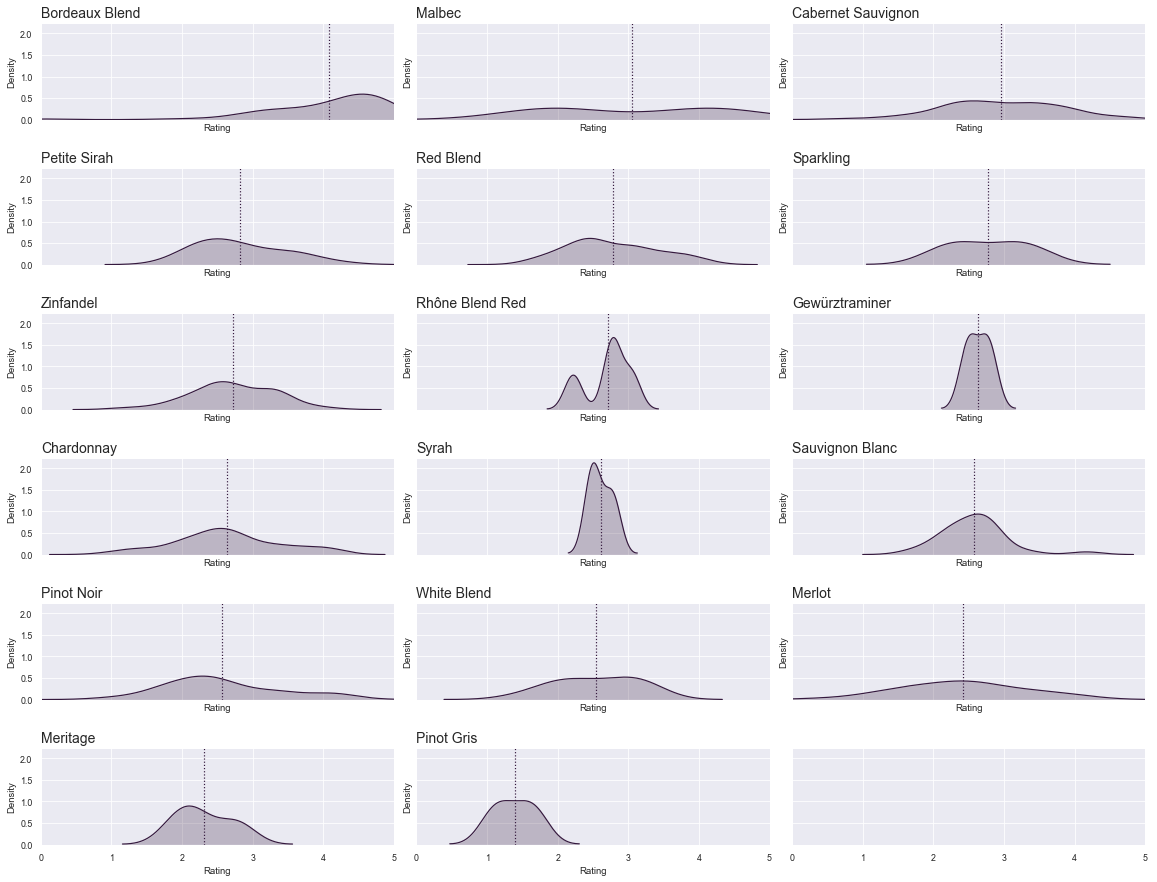

In [73]:
sns.set_palette("rocket")
sns.set_style("darkgrid")

wine_types = wine_data.groupby(by='wine_type').mean().sort_values('ratings_average',ascending=False)['ratings_average']
num_wine_types = len(wine_types)
num_rows = math.ceil(num_wine_types/3)

fig, axes = plt.subplots(num_rows, 3,figsize=(16, 2*num_rows), sharex=True, sharey=True)
fig.tight_layout(h_pad=4)

for n in range(num_wine_types):
    
    row = int(n/3)
    col = n%3
    
    wine_type = wine_types.index[n]
    

    sns.kdeplot(wine_data.loc[(wine_data['wine_type'] == wine_type),'ratings_average']*5, 
                shade=True, legend=False, ax=axes[row,col])
    
    axes[row,col].axvline(wine_types[n]*5, 0, ls='dotted')
    
    fontdict = {
        'fontsize': 14,
        'fontweight' : 'normal'
    }

    axes[row,col].set_title(wine_type, fontdict=fontdict, loc='left')
    axes[row,col].set_xlabel('Rating')
    axes[row,col].set_ylabel('Density')
    axes[row,col].set_xlim(0,5)
    axes[row,col].axes.xaxis.set_visible(True)
    